# Visualization results for the report

## Import requirements and utility codes

In [72]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

from collections import OrderedDict

from tqdm.auto import tqdm
import os
import math
import matplotlib.pyplot as plt
import logging

from utils.dataset import *
from utils.misc import *
from utils.data import *
from models.vae_gaussian import *
from models.vae_flow import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def rotate_points(points, angle_x, angle_y, angle_z):
    # Convert angles from degrees to radians
    angle_x = np.radians(angle_x)
    angle_y = np.radians(angle_y)
    angle_z = np.radians(angle_z)

    # Create rotation matrices
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])

    Ry = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])

    Rz = np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ])

    # Rotate points
    rotated_points = points @ Rx @ Ry @ Rz

    return rotated_points

def visualize_3d(points, angle_x, angle_y, angle_z):
    # Create a figure and a 3D axes object
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Rotate points
    points = rotate_points(points, angle_x, angle_y, angle_z)

    # Extract the x, y, and z coordinates from the 3D array
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # Plot the points as a scatter plot
    ax.scatter(x, y, z, s=1)

    # Hide labels and axes
    plt.axis('off')
    
    return fig, ax

if not os.path.exists("figures"):
    os.mkdir("figures")
    print("Figures folder created.")
else:
    print("Figures folder existed.")

Figures folder existed.


## Figure 5.

Generated Point Clouds: This figure displays ten samples of point clouds generated by the
proposed model using the ResNet encoder, with the first row illustrating samples from the airplane
category and the second row from the car category

Processing airplane
Processing car


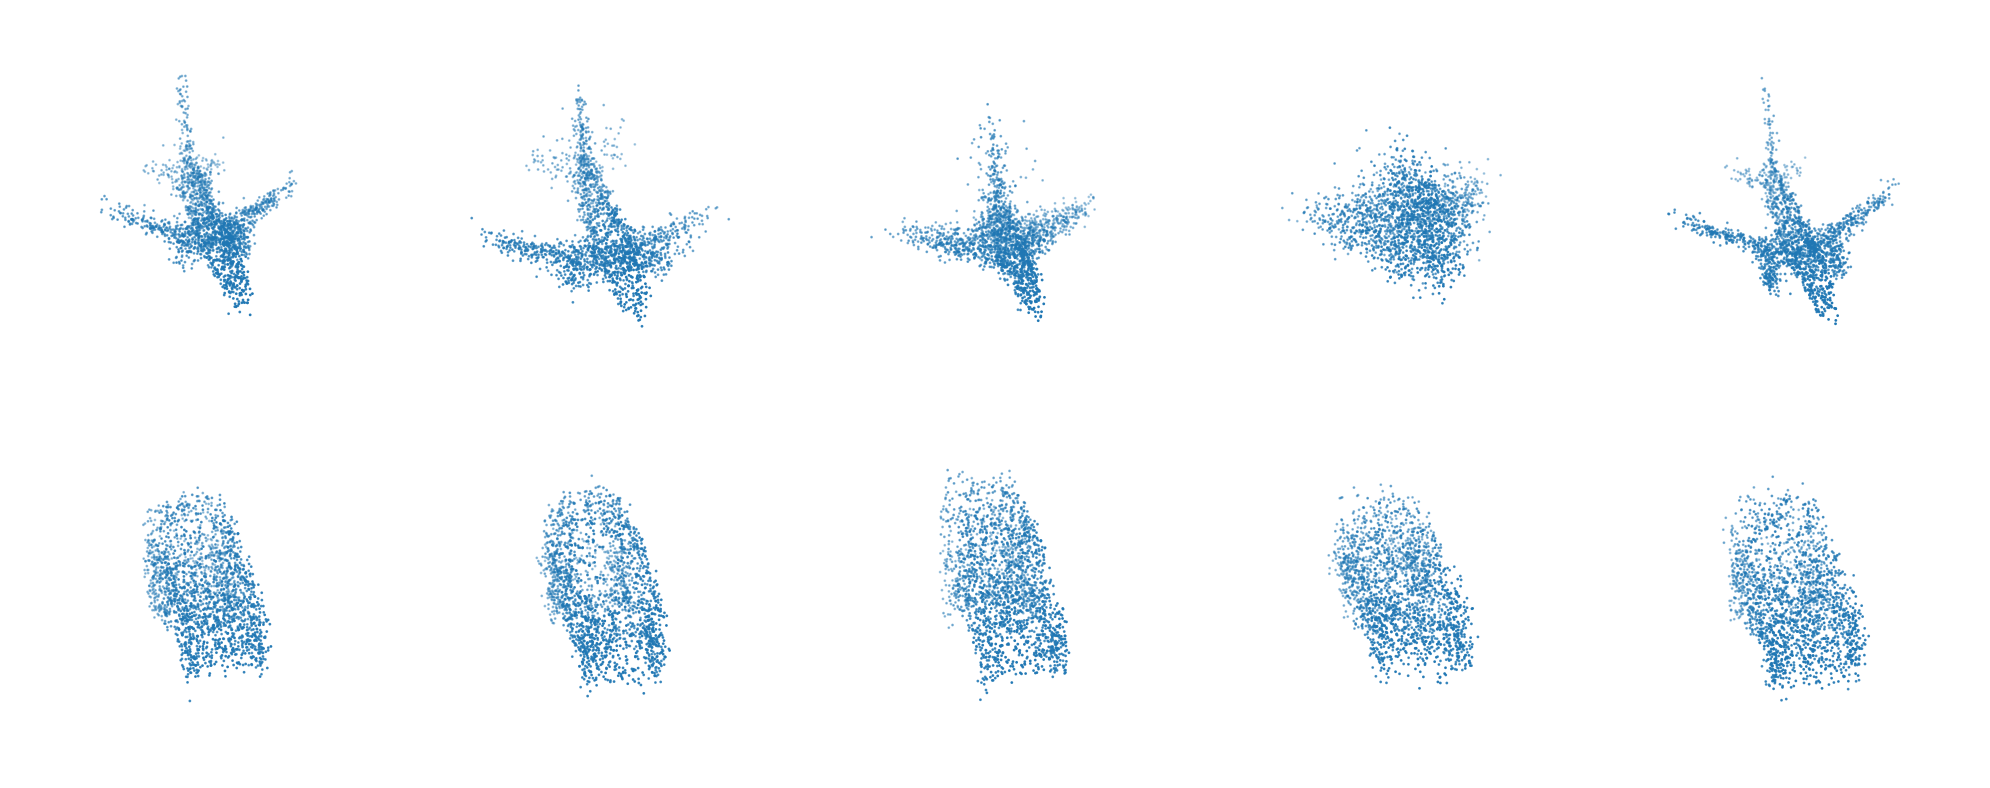

In [74]:
# visualize pretrained example result
n_objects = 5
point_file_paths = OrderedDict({
    "airplane": "/data/dongyin/logs_gen/results/GEN_Ours_car_1686692959/out.npy",
    "car": "/data/dongyin/logs_gen/results/GEN_Ours_airplane_1686692525/out.npy"
})

nrows = len(point_file_paths)
ncols = n_objects

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), subplot_kw={"projection":'3d'})

for class_idx, (class_name, file_path) in enumerate(point_file_paths.items()):
    print(f"Processing {class_name}")
    out = np.load(file_path)
    for obj_idx in range(n_objects):
        points = out[obj_idx]
        points = rotate_points(points, -90, 0, 135)
        # Extract the x, y, and z coordinates from the 3D array
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        # Plot the points as a scatter plot
        axes[class_idx][obj_idx].scatter(x, y, z, s=1)
        axes[class_idx][obj_idx].set_axis_off()
        
plt.tight_layout()
fig.savefig("figures/examples_resnet.pdf")
plt.show()

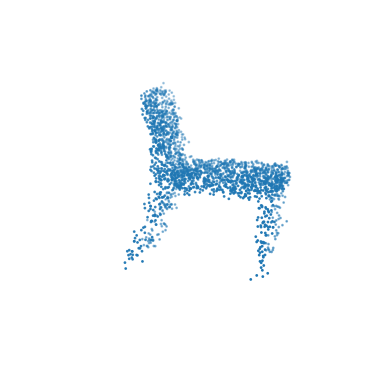

In [64]:
out = np.load(point_file_paths["chair"])
points = out[2]
fig, ax = visualize_3d(points, -90, 30, 70)
plt.show()

## Visualizing the ShapeNet dataset

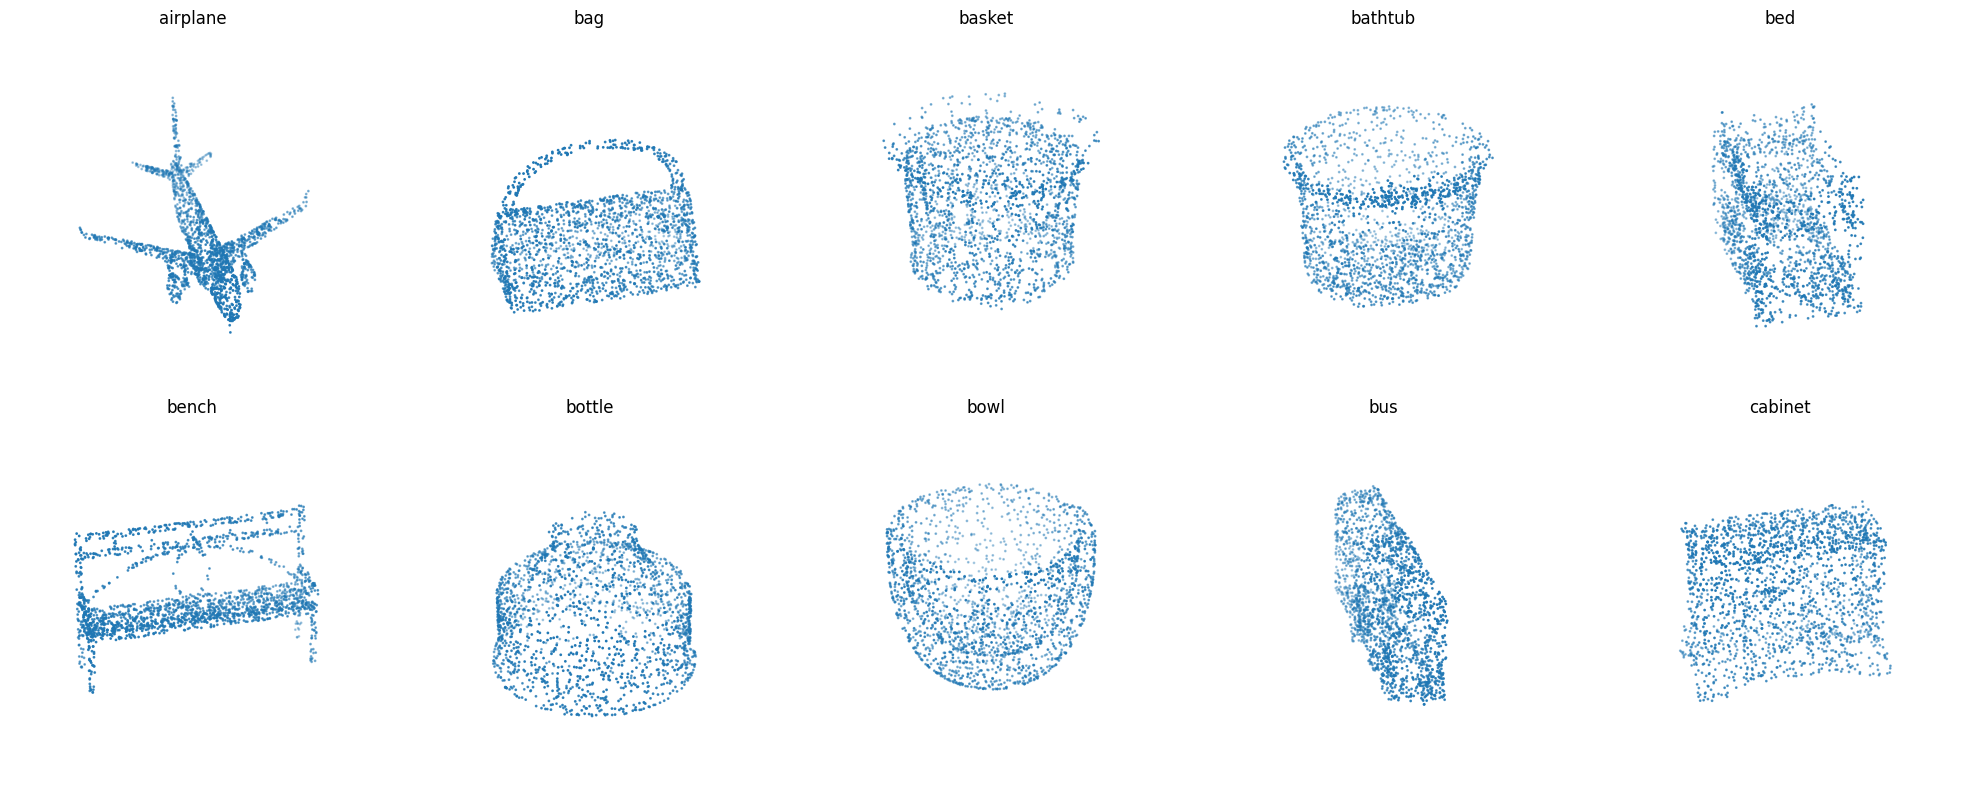

In [23]:
# visualizing dataset Shapenet
from utils.dataset import synsetid_to_cate, ShapeNetCore

n_rows = 2
n_cols = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows), subplot_kw={"projection":'3d'})
axes = axes.ravel()

cats = synsetid_to_cate.values()
cats = list(cats)[:10]

for ax_idx, cat in enumerate(cats):
    dset = ShapeNetCore(
        path="/data/dongyin/diffusion-point-cloud/data/shapenet.hdf5",
        cates=[cat],
        split='train',
        scale_mode='shape_unit'
    )

    points = dset[0]['pointcloud']
    points = rotate_points(points, -90, 0, 135)
    # Extract the x, y, and z coordinates from the 3D array
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # Plot the points as a scatter plot
    axes[ax_idx].scatter(x, y, z, s=1)

    axes[ax_idx].set_title(cat)

    axes[ax_idx].set_axis_off()
plt.tight_layout()
plt.show()

fig.savefig("figures/shapenet_viz.pdf")

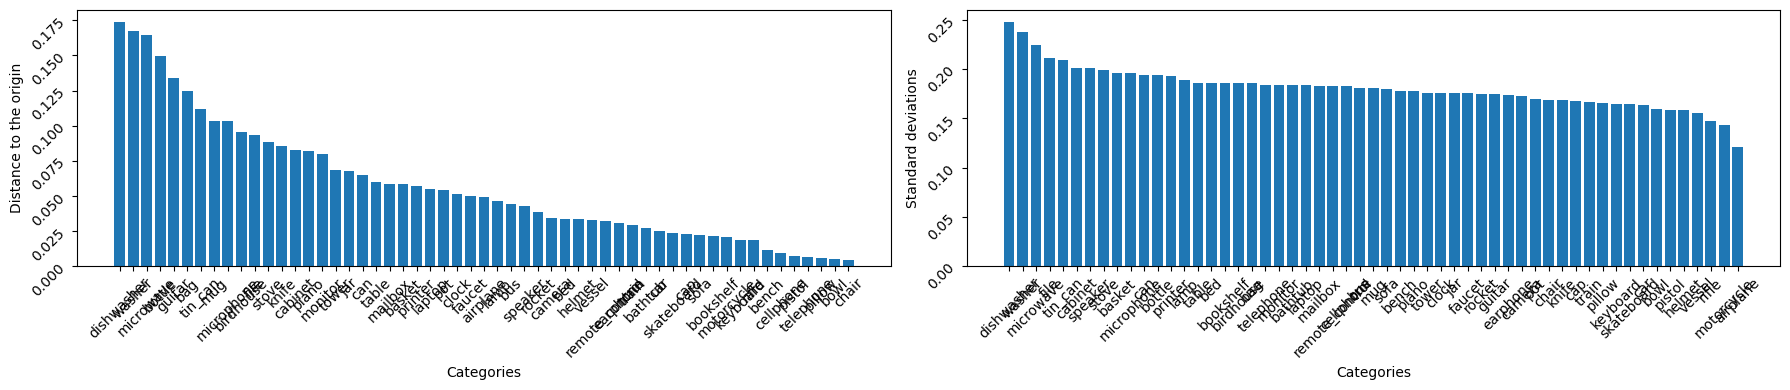

In [52]:
# visualize shapenet statistics
cats = list(synsetid_to_cate.values())

means = []
stds = []

for idx, cat in enumerate(cats):
    dset = ShapeNetCore(
        path="/data/dongyin/diffusion-point-cloud/data/shapenet.hdf5",
        cates=[cat],
        split='train',
        scale_mode='shape_unit'
    )
    stats= dset.get_statistics()
    means.append(stats["mean"].numpy())
    stds.append(stats["std"].numpy())

dists = [np.linalg.norm(mu) for mu in means]

fig, axes = plt.subplots(ncols=2, figsize=(9*2, 4))

cats = np.array(cats)
dists = np.array(dists)
stds = np.array(stds)

dists_idx = np.argsort(dists)[::-1]
axes[0].bar(range(len(cats)), dists[dists_idx])
axes[0].set_xlabel("Categories")
axes[0].set_ylabel("Distance to the origin")
axes[0].set_xticks(range(len(cats)), cats[dists_idx])
axes[0].tick_params(labelrotation=45)

std_idx = np.argsort(stds)[::-1]
axes[1].bar(range(len(cats)), stds[std_idx])
axes[1].set_xlabel("Categories")
axes[1].set_ylabel("Standard deviations")
axes[1].set_xticks(range(len(cats)), cats[std_idx])
axes[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()
fig.savefig("figures/std_distance.pdf")

## For final reports: more visualiazations and objective metrics

In [78]:
device="cuda:1"

# visualize progression over training
def normalize_point_clouds(pcs, mode, logger):
    if mode is None:
        logger.info('Will not normalize point clouds.')
        return pcs
    logger.info('Normalization mode: %s' % mode)
    for i in range(pcs.size(0)):
        pc = pcs[i]
        if mode == 'shape_unit':
            shift = pc.mean(dim=0).reshape(1, 3)
            scale = pc.flatten().std().reshape(1, 1)
        elif mode == 'shape_bbox':
            pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
            pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
            shift = ((pc_min + pc_max) / 2).view(1, 3)
            scale = (pc_max - pc_min).max().reshape(1, 1) / 2
        pc = (pc - shift) / scale
        pcs[i] = pc
    return pcs

# Define the test function
def generate_point_clouds(model, ckpt_args, args):
    # implement your test function here
    gen_pcs = []
    for i in tqdm(range(0, math.ceil(ckpt_args.test_size / ckpt_args.val_batch_size)), 'Generate'):
        with torch.no_grad():
            z = torch.randn([ckpt_args.val_batch_size, ckpt_args.latent_dim]).to(device)
            x = model.sample(z, ckpt_args.sample_num_points, flexibility=ckpt_args.flexibility)
            gen_pcs.append(x.detach().cpu())
    gen_pcs = torch.cat(gen_pcs, dim=0)
    if args.normalize is not None:
        gen_pcs = normalize_point_clouds(gen_pcs, mode=args.normalize, logger=logging.getLogger())
    
    return gen_pcs

def get_metrics(gen_pcs, val_dset, ckpt_args):
    ref_pcs = []
    for i, data in enumerate(val_dset):
        if i >= ckpt_args.test_size:
            break
        ref_pcs.append(data['pointcloud'].unsqueeze(0))
    ref_pcs = torch.cat(ref_pcs, dim=0)

    with torch.no_grad():
        results = compute_all_metrics(gen_pcs.to(device), ref_pcs.to(device), ckpt_args.val_batch_size)
        results = {k:v.item() for k, v in results.items()}
        jsd = jsd_between_point_cloud_sets(gen_pcs.cpu().numpy(), ref_pcs.cpu().numpy())
        results['jsd'] = jsd

    return results

# Specify the directory where your checkpoints are saved
def visualize_progress(checkpoint_dir, args):
    # List all checkpoint files
    checkpoint_files = [
        f for f in os.listdir(checkpoint_dir) if f.startswith('ckpt') and f.endswith('.pt')
    ]
    # checkpoint_files = checkpoint_files[20:40]

    # calculate the size of image
    ncols = 10
    nrows = math.ceil(len(checkpoint_files)/ncols)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4),
        subplot_kw={"projection":'3d'}
    )
    axes = axes.ravel()

    # Initialize and test model for each checkpoint
    for checkpoint_index in tqdm(range(len(checkpoint_files)), desc="Checkpoint files"):
        # Load checkpoint
        checkpoint_file = checkpoint_files[checkpoint_index]
        checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location=device)

        # Extract args and state_dict
        ckpt_args = checkpoint['args']
        state_dict = checkpoint['state_dict']

        if not hasattr(ckpt_args, "encoder"):
            setattr(ckpt_args, "encoder", "pointnet")
        if not hasattr(ckpt_args, "diffusion_layer_type"):
            setattr(ckpt_args, "diffusion_layer_type", "squash")

        # Initialize model
        if ckpt_args.model == 'gaussian':
            model = GaussianVAE(ckpt_args).to(device)
        elif ckpt_args.model == 'flow':
            model = FlowVAE(ckpt_args).to(device)
        model.load_state_dict(state_dict)

        # Test model
        gen_pcs = generate_point_clouds(model, ckpt_args, args)

        # visualize pc
        points = rotate_points(gen_pcs[0], -90, 0, 135)
        # Extract the x, y, and z coordinates from the 3D array
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]

        # Plot the points as a scatter plot
        axes[checkpoint_index].scatter(x, y, z, s=1)
        axes[checkpoint_index].set_title(checkpoint_index*1000)
        axes[checkpoint_index].set_axis_off()

    plt.tight_layout()
    fig.savefig(f"figures/progression.pdf")
    plt.show()

def visualize_comparison(nrows, ncols, ckpt_folders, iteration, args, ckpt_root="logs_gen", test_size=100):
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4),
        subplot_kw={"projection":'3d'}
    )
    axes = axes.ravel()

    for axes_idx, (setting, ckpt_folder) in enumerate(ckpt_folders.items()):
        checkpoint = torch.load(
            os.path.join(ckpt_root, ckpt_folder, f"ckpt_0.000000_{iteration}.pt"), map_location=device
        )
        
        # Extract args and state_dict
        ckpt_args = checkpoint['args']
        setattr(ckpt_args, "test_size", test_size)
        state_dict = checkpoint['state_dict']

        if not hasattr(ckpt_args, "encoder"):
            setattr(ckpt_args, "encoder", "pointnet")
        if not hasattr(ckpt_args, "diffusion_layer_type"):
            setattr(ckpt_args, "diffusion_layer_type", "squash")

        # Initialize model
        if ckpt_args.model == 'gaussian':
            model = GaussianVAE(ckpt_args).to(device)
        elif ckpt_args.model == 'flow':
            model = FlowVAE(ckpt_args).to(device)
        model.load_state_dict(state_dict)

        # Test model
        gen_pcs = generate_point_clouds(model, ckpt_args, args)

        # get metrics
        val_dset = ShapeNetCore(
            path=ckpt_args.dataset_path,
            cates=ckpt_args.categories,
            split='val',
            scale_mode=ckpt_args.scale_mode,
        )
        results = get_metrics(gen_pcs, val_dset, ckpt_args)
        print(setting, results)

        # visualize pc
        points = rotate_points(gen_pcs[0], -90, 0, 135)
        # Extract the x, y, and z coordinates from the 3D array
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]

        # Plot the points as a scatter plot
        axes[axes_idx].scatter(x, y, z, s=1)
        axes[axes_idx].set_title(setting)
        axes[axes_idx].set_axis_off()

    plt.tight_layout()
    fig.savefig(f"figures/comparison_{iteration}.pdf")
    plt.show()

class TestArgs:
    def __init__(self):
        self.categories = "airplane"
        self.save_dir = './results'
        self.device = 'cuda'
        self.dataset_path = '/data/dongyin/diffusion-point-cloud/data/shapenet.hdf5'
        self.batch_size = 128
        self.sample_num_points = 2048
        self.normalize = 'shape_bbox'
        self.seed = 9988
test_args = TestArgs()

In [ ]:
visualize_progress("./logs_gen/GEN_2023_06_06__14_24_05", test_args)

### Table 1 and Figure 4

Table 1: Evaluation metrics for customized models.

Figure 4: Comparison of generated point clouds from the baseline model, Gaussian prior model, ResNet encoder model, and backward diffusion with concatenation linear layer model.

In [ ]:
# 10-categories
ckpt_folders = {
    "Baseline": "GEN_2023_06_12__17_24_49", 
    "ResNet Encoder": "GEN_2023_06_12__17_43_23"
}
visualize_comparison(1, len(ckpt_folders), ckpt_folders, 5000, test_args, ckpt_root="/data/dongyin/logs_gen")

Generate:   0%|          | 0/2 [00:00<?, ?it/s]

Generate:   0%|          | 0/2 [00:00<?, ?it/s]

using resnet encoder.


Generate:   0%|          | 0/2 [00:00<?, ?it/s]

using non squash pointwise net.


Generate:   0%|          | 0/2 [00:00<?, ?it/s]

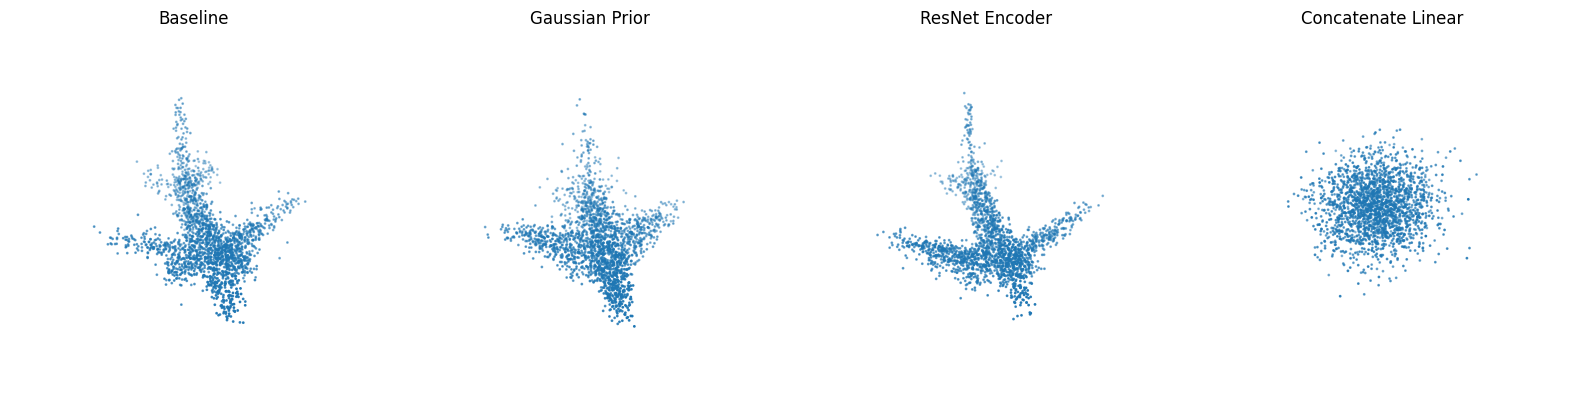

In [21]:
# cars
ckpt_folders = {
    "Baseline": "GEN_2023_06_06__13_55_54", 
    "Gaussian Prior": "GEN_2023_06_06__14_24_05",
    "ResNet Encoder": "GEN_2023_06_06__16_11_56",
    "Concatenate Linear": "GEN_2023_06_06__17_08_34"
}
visualize_comparison(1, len(ckpt_folders), ckpt_folders, 5000, test_args)

Generate:   0%|          | 0/2 [00:00<?, ?it/s]

Generate:   0%|          | 0/2 [00:00<?, ?it/s]

using resnet encoder.


Generate:   0%|          | 0/2 [00:00<?, ?it/s]

using non squash pointwise net.


Generate:   0%|          | 0/2 [00:00<?, ?it/s]

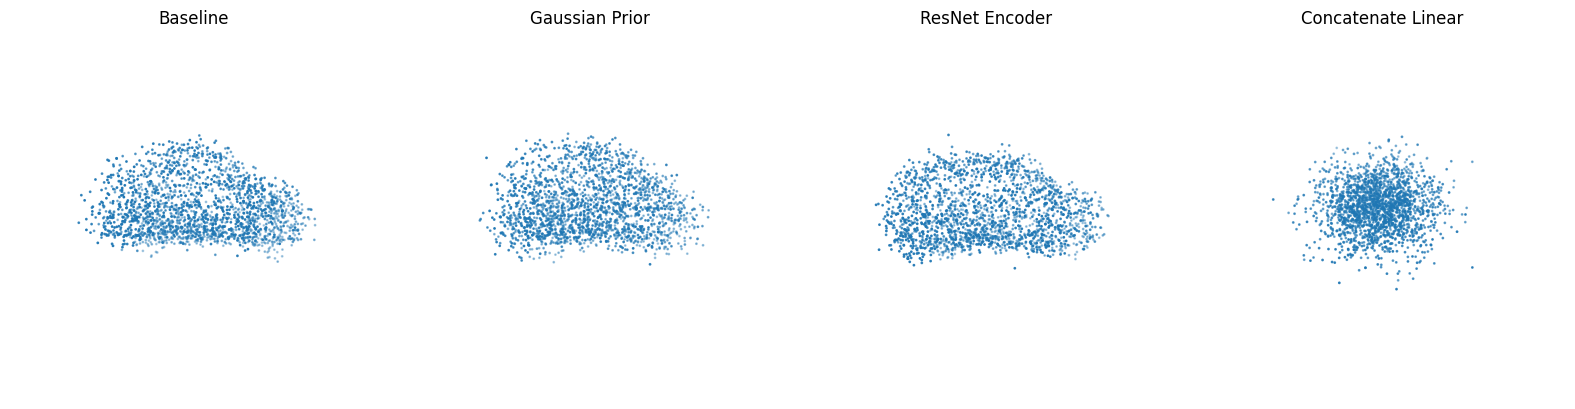

In [67]:
# cars
ckpt_folders = {
    "Baseline": "GEN_2023_06_13__11_10_42", 
    "Gaussian Prior": "GEN_2023_06_13__11_13_08",
    "ResNet Encoder": "GEN_2023_06_13__11_13_50",
    "Concatenate Linear": "GEN_2023_06_13__11_14_21"
}
visualize_comparison(1, len(ckpt_folders), ckpt_folders, 5000, test_args, ckpt_root="/data/dongyin/logs_gen")

### Figure 6. 

Comparing the t-SNE visualization of latent representations obtained from the PointNet and ResNet encoder.

In [30]:
# t-sne visualization for two encoders
from tsne_torch import t_sne
from sklearn.manifold import TSNE
device = "cpu"

def tsne_visualization(nrows, ncols, ckpt_folders, iteration, args, ckpt_root="logs_gen"):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4), sharex="all", sharey="all")
    axes = axes.ravel()

    # Define a colormap
    cmap = cm.get_cmap('tab10')

    # Get the number of unique classes
    num_classes = 10
    
    for axes_idx, (setting, ckpt_folder) in enumerate(ckpt_folders.items()):
        checkpoint = torch.load(
            os.path.join(ckpt_root, ckpt_folder, f"ckpt_0.000000_{iteration}.pt"), map_location=device
        )
        
        # Extract args and state_dict
        ckpt_args = checkpoint['args']
        state_dict = checkpoint['state_dict']

        if not hasattr(ckpt_args, "encoder"):
            setattr(ckpt_args, "encoder", "pointnet")
        if not hasattr(ckpt_args, "diffusion_layer_type"):
            setattr(ckpt_args, "diffusion_layer_type", "squash")

        # Initialize model
        if ckpt_args.model == 'gaussian':
            model = GaussianVAE(ckpt_args).to(device)
        elif ckpt_args.model == 'flow':
            model = FlowVAE(ckpt_args).to(device)
        model.load_state_dict(state_dict)

        # Construct embeddings from various classes
        ref_pcs = []
        labels = []
        for cat_idx, cat in enumerate(ckpt_args.categories):
            val_dset = ShapeNetCore(
                path=ckpt_args.dataset_path,
                cates=[cat],
                split='val',
                scale_mode=ckpt_args.scale_mode,
            )

            count = 0
            for i, data in enumerate(val_dset):
                if i >= 64:
                    break
                ref_pcs.append(data['pointcloud'].unsqueeze(0))
                count += 1
            labels = labels + [cat_idx] * count

        ref_pcs = torch.cat(ref_pcs, dim=0).to(device)
        z_mu, z_sigma = model.encoder(ref_pcs)
        z_mu = z_mu.detach().clone().cpu().numpy()

        # z = reparameterize_gaussian(mean=z_mu, logvar=z_sigma)  # (B, F)
        # Y = t_sne(z_mu, num_iterations=100).cpu().numpy()
        # Create a t-SNE instance with desired parameters
        tsne = TSNE(n_components=2, random_state=42)

        # Apply t-SNE to the data
        X_embedded = tsne.fit_transform(z_mu)
        np.save(f"/data/dongyin/X_embedded_{setting}.npy", X_embedded)

        # print(Y.shape)
        axes[axes_idx].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[axes_idx].set_title(setting)
    
    # fig.legend(ckpt_args.categories, loc="upper center", ncols=len(ckpt_args.categories))
    plt.tight_layout()
    fig.savefig(f"figures/tsne.pdf")
    plt.show()

/tmp/ipykernel_1344516/1688073287.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


using resnet encoder.


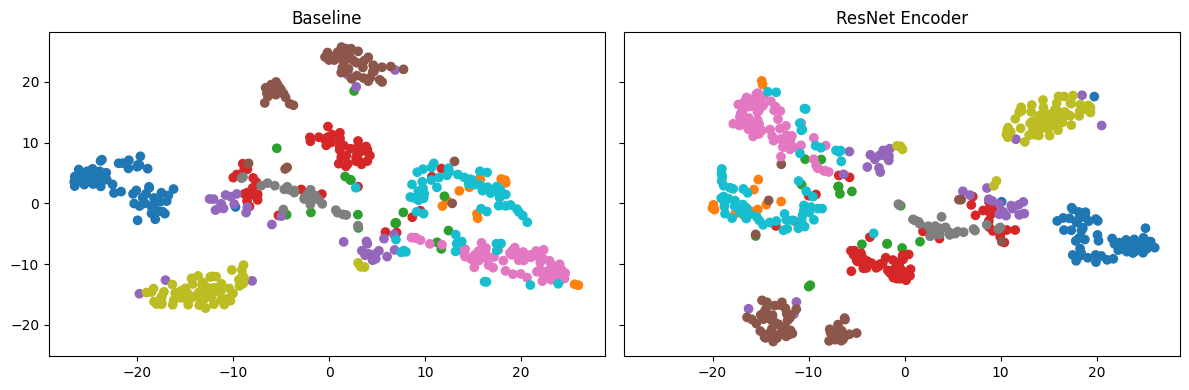

In [32]:
ckpt_folders = {
    "Baseline": "GEN_2023_06_12__17_24_49", 
    "ResNet Encoder": "GEN_2023_06_12__17_43_23",
}

tsne_visualization(1, 2, ckpt_folders, 5000, test_args, ckpt_root="/data/dongyin/logs_gen")